In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.H5pySimple import ReadFromH5py,SaveToH5py
from BabelViscoFDTD.PropagationModel import PropagationModel
from scipy import ndimage
from skimage.draw import circle_perimeter,disk
from skimage.transform import rotate
from ipywidgets import  HBox, VBox, GridBox, Layout, Label, IntSlider, interact,\
    Checkbox,GridspecLayout,interactive, widgets, FloatSlider
from IPython.display import display

PModel=PropagationModel()
COMPUTING_BACKEND=3 # 0 for CPU, 1 for CUDA, 2 for OpenCL, 3 for Metal
DefaultGPUDeviceName='M1' # ID of GPU

StaggeredFDTD_3D_CPU loaded
StaggeredFDTD_3D_CUDA NOT loaded
StaggeredFDTD_3D_OPENCL loaded
StaggeredFDTD_3D_METAL loaded


### Preamble
Please consult the previous examples for the basics how to run a simulation, understanding of how to prepare correctly the directivity of a source and how to prepare a focusing source


In this example, we perform several testd of transmission through solid lossless material

# 1- Water - lossless attenuating solid


Domain size 297 161 270


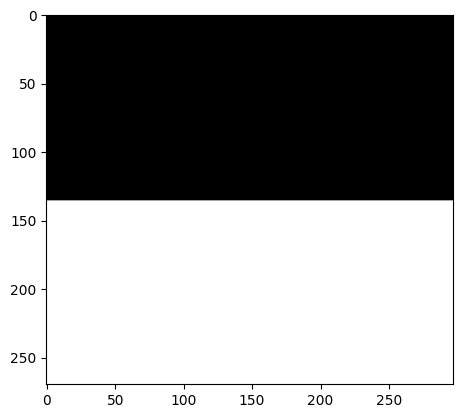

In [2]:
Frequency = 350e3  # Hz
WaterSOS = 1500 # m/s - water
WaterDensity=1000 # kg/m3

#Acryic
SolidLSOS = 2848 # m/s - 
SolidsSOS = 1026 # m/s - 
SolidDensity=1190 # kg/m3

Amplitude=100e3/WaterSOS/WaterDensity # 100 kPa

ShortestWavelength =SolidsSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.1,0.05,0.09])  # in m, x,y,z  # in m, x,y,z

TxRadius = 0.04 # m, 
TxDiameter=0.04
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, HIGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/(np.mean([SolidsSOS,WaterSOS])) #time to cross one corner to another
TemporalStep=5e-8 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidsSOS # plastic shear SoS

#we define two - half spaces

MaterialMap[:,:,int(N3/2)+1:]=1

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

#all other parameters are set to 0 


We apply the concepts on directivity to model a spherical cap for a focusing source. Below there is a function that uses scikit-image to prepare the mask of a spherical cap and how we can prepare correctly the directivity of each entry in the source mask.

In [3]:
def MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,Angle):
    #simple defintion of a focusing source centred in the domain, 
    #please note this is not a bullet-proof solution as it may not work for all cases
    XDim=np.arange(N1)*SpatialStep
    YDim=np.arange(N2)*SpatialStep
    ZDim=np.arange(N3)*SpatialStep
    XDim-=XDim[int(N1/2)]
    YDim-=YDim[int(N2/2)]
    ZDim-=ZDim[int(N3/2)]
    XX,YY,ZZ=np.meshgrid(YDim,XDim,ZDim)#note we have to invert this because how meshgrid works
    Depth=np.sqrt(TxRadius**2-(TxDiameter/2.0)**2)
    cX=int(N1/2)
    cZ=int(N3/2)
    
    MaskSource=np.zeros((N1,N2,N3),np.bool_)
    FillMask=np.zeros((N1,N2,N3))
    
    for n,y in enumerate(YDim):
        if np.abs(y)<TxRadius:
            cDiam=int(np.ceil(TxRadius*np.sin(np.arccos(y/TxRadius))/SpatialStep))
            rr, cc = circle_perimeter(cX,cZ,cDiam,shape=(N1,N3))
            MaskSource[rr,n,cc]=np.True_
            rr,cc=disk((cX,cZ),cDiam+1,shape=(N1,N3))
            FillMask[rr,n,cc]=1
            
    
    FillMask[ZZ<=-Depth]=0.
    #instead of rotating the arc, we rotate the mask that will negate the perimeter to be turned off
    if Angle!=0.:
        for n in range(N2):
            FillMask[:,n,:]=rotate(FillMask[:,n,:],Angle,preserve_range=True)
        
    MaskSource[FillMask!=0]=False
        
    #since the sphere mask is 0-centred, the orientation vectors in each point is straighforward
    OxOyOz=np.vstack((-XX.flatten(),-YY.flatten(),-ZZ.flatten())).T
    #and we just normalize
    OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])
    Ox=OxOyOz[:,1].reshape(XX.shape) 
    Oy=OxOyOz[:,0].reshape(XX.shape)
    Oz=OxOyOz[:,2].reshape(XX.shape)
    Ox[MaskSource==False]=0
    Oy[MaskSource==False]=0
    Oz[MaskSource==False]=0
    return MaskSource.astype(np.uint32),Ox,Oy,Oz

We use a rotated focusing source so we can analyze the multiple stress that are generated once the acoustic beam reaches the solid

/var/folders/5s/12dkrmtj48df4qxdb694k5g00000gn/T/ipykernel_66728/2928031939.py:38: RuntimeWarning: invalid value encountered in divide
  OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])


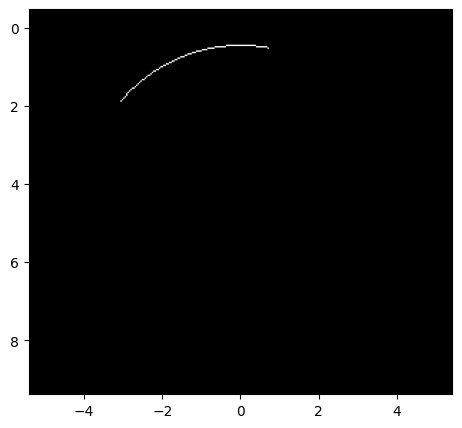

In [4]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-20)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);

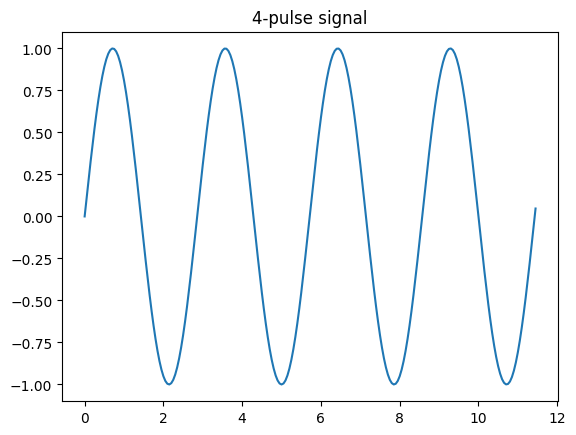

In [5]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

In [6]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

### Collect stress data
So far in the previous examples, we have collected only particle displacement, this time we will specify to collect stress data both for 3D maps and sensor data

In [7]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*Amplitude,
                                                         Oy=Oy*Amplitude,
                                                         Oz=Oz*Amplitude,
                                                         NDelta=PMLThickness,
                                                         DT=TemporalStep,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         SelMapsRMSPeakList=['Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=4,
                                                         TypeSource=0)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 5e-08 6.303432725005773e-08
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2273, temporal step = 5e-08, total sonication length 0.00011364 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 7
Allocating for V_x_x 3753415 elements
Allocating for V_y_x 3753415 elements
Allocating for V_z_x 3753415 elements
Allocating for V_x_y 3790135 elements
Allocating for V_y_y 3790135 elements
Allocating for V_z_y 3790135 elements
Allocating for V_x_z 3757762 elements
Allocating for V_y_z 3757762 elements
Allocating for V_z_z 37

We can see now that the multiple matrices were returned

In [8]:
print(DictRMSValue.keys())

dict_keys(['Sigmaxx', 'Sigmayy', 'Sigmazz', 'Sigmaxy', 'Sigmaxz', 'Sigmayz', 'Pressure'])


### Ploting data

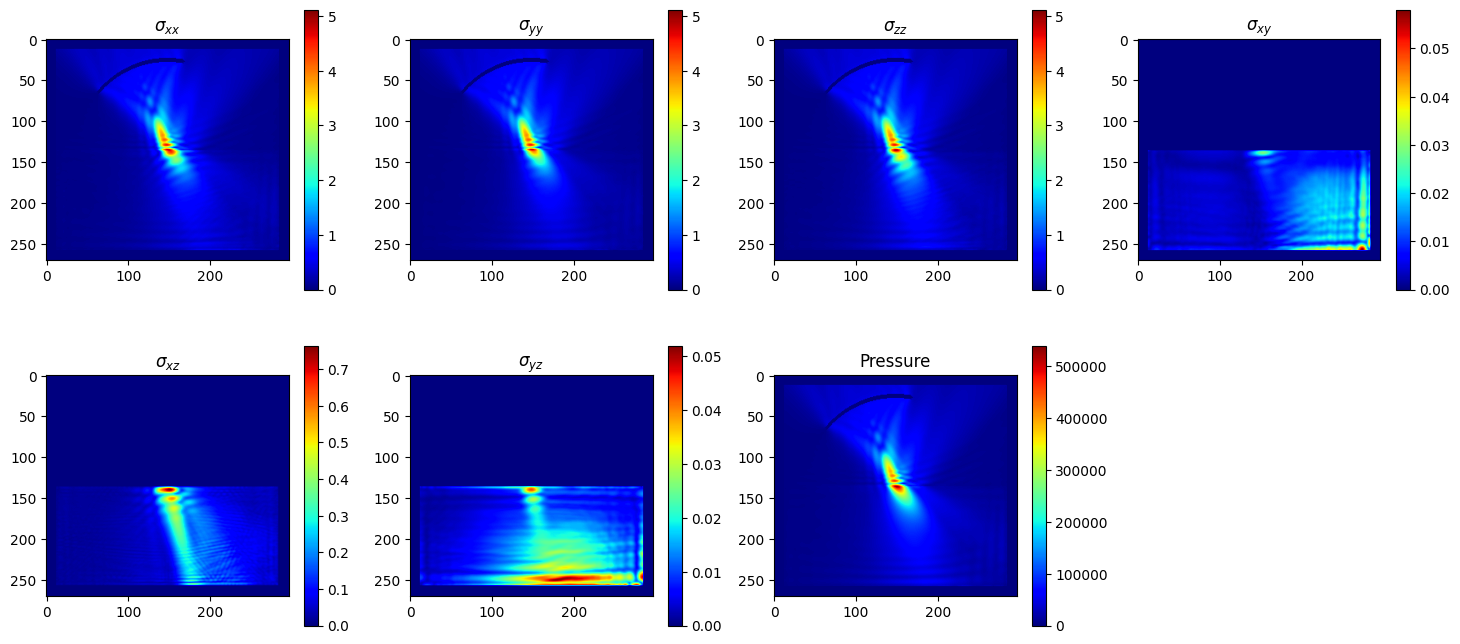

In [9]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    plt.imshow(selP.T,cmap=plt.cm.jet)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


As the pressure is the result the divergence of the three $V$ components, it shows very clearly the refaction effect of the water-liquid interface

### Plot sensor data maps over time
As we collected sensor data for $V_x$, $V_y$, $V_y$, $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{zz}$, $\sigma_{xy}$, $\sigma_{xz}$, and $\sigma_{xz}$ , we can plot them using a widget to scroll the data over time

In [10]:
class ShowTimeData(object):
    def __init__(self,N1,N2,N3,InputParam,SourceMap,Sensor,Skip=1):
        nL=Sensor['Vx'].shape[1]
        IndTime=np.arange(0,nL,Skip)
        SensorPlane={}
        for k in Sensor:
            if k=='time':
                continue
            SensorPlane[k]=np.zeros((N1,N3,len(IndTime)))
        BInd=[]
        for n, index in enumerate( InputParam['IndexSensorMap']): 
            k=int(index/(N1*N2))
            j=int(index%(N1*N2))
            i=int(j%N1)
            j=int(j/N1)
            BInd.append([i,j,k])
        BInd=np.array(BInd)
        for k in SensorPlane:
            for nt,et in enumerate(IndTime):
                SensorPlane[k][BInd[:,0],BInd[:,2],nt]=Sensor[k][:,et]
            if 'Sigma' in k:
                SensorPlane[k]/=1e5
            if 'Pressure'==k:
                SensorPlane[k]/=1e6
        self.SensorPlane=SensorPlane
        self.fig=None
        
    def PlotTimePoint(self,timep=0):
        if self.fig:
            plt.close(self.fig)
        
        self.fig=plt.figure(figsize=(16,16))
        n=1
        for k in  self.SensorPlane:
            plt.subplot(4,3,n)
            plt.imshow(self.SensorPlane[k][:,:,timep].T,cmap=plt.cm.jet)
            plt.colorbar()
            n+=1
            if 'V' in k:
                plt.title('$V_'+k.split('V')[1]+'$')
            elif 'Sigma' in k:
                plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
            else:
                plt.title(k)
        plt.show()
        
    def SelectTimePoint(self):
        Sel=IntSlider(description='Time point',value=0,
                        min=0,max=self.SensorPlane[list(self.SensorPlane.keys())[0]].shape[2]-1,step=1,continuous_update=False,
                        layout=Layout(width='75%'),style={'description_width': 'initial'})
        interact(self.PlotTimePoint,timep=Sel)
       
        

In [11]:
ShowTimeData(N1,N2,N3,InputParam,SourceMap,Sensor).SelectTimePoint()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time point', layout=Layout(widt…

Because the orientation of the transducer rotated along the $Y$ axis, we can clearly see the P-wave (faster and with longer wavelength) in $\sigma_{xx}$ and $\sigma_{zz}$, and the S-wave (slower and with shorter wavelength) in $\sigma_{xy}$, $\sigma_{xz}$, $\sigma_{yz}$

# Solid surrounded by water

Now this time we simulate the case a block of plastic (1.4 cm-thick) is surrounded by water

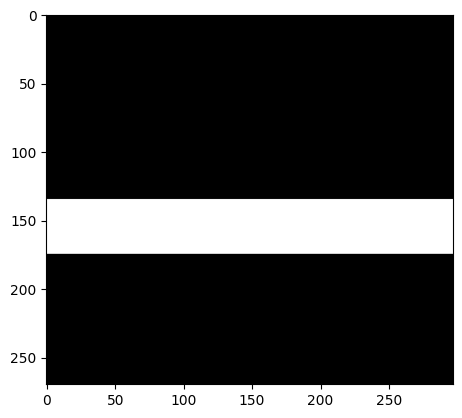

In [12]:
MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidsSOS # plastic shear SoS

#we define two - half spaces

MaterialMap[:,:,int(N3/2):int(N3/2)+40]=1

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);


In [13]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*Amplitude,
                                                         Oy=Oy*Amplitude,
                                                         Oz=Oz*Amplitude,
                                                         NDelta=PMLThickness,
                                                         DT=TemporalStep,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         SelMapsRMSPeakList=['Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=4,
                                                         TypeSource=1)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 5e-08 6.303432725005773e-08
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2273, temporal step = 5e-08, total sonication length 0.00011364 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 7
Allocating for V_x_x 3753415 elements
Allocating for V_y_x 3753415 elements
Allocating for V_z_x 3753415 elements
Allocating for V_x_y 3790135 elements
Allocating for V_y_y 3790135 elements
Allocating for V_z_y 3790135 elements
Allocating for V_x_z 3757762 elements
Allocating for V_y_z 3757762 elements
Allocating for V_z_z 37

### Ploting data

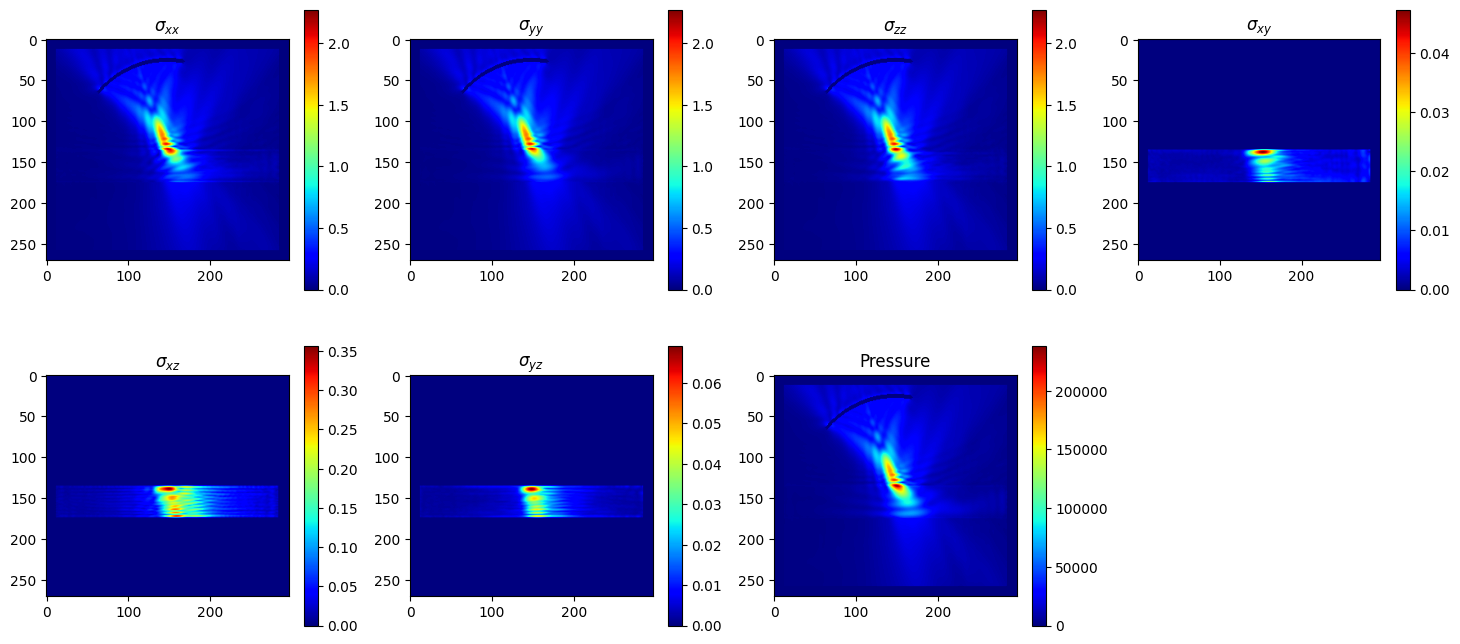

In [14]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    plt.imshow(selP.T,cmap=plt.cm.jet)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


In [15]:
ShowTimeData(N1,N2,N3,InputParam,SourceMap,Sensor).SelectTimePoint()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time point', layout=Layout(widt…

We can appreciate in the all "All_V" and "Pressure" maps that two patterns appear in the far field water domain, indicating the longitudinal and shear type conversion. The longitudinal transmission being the field more refracted.

In the temporal map plots, we can also appreciate the multiple internal reflections in the layer of plastic, including transmitted waves in both upper and lower water regions.

# Above critical angle
The previous example used an acoustic beam hitting the block material with an inciden angle of 20 degrees. The critical angle for this material is around 38 degrees. To show only shear-type transmission through the solid, this time we run the simulation with an incident angle of 45 degrees.

/var/folders/5s/12dkrmtj48df4qxdb694k5g00000gn/T/ipykernel_66728/2928031939.py:38: RuntimeWarning: invalid value encountered in divide
  OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])


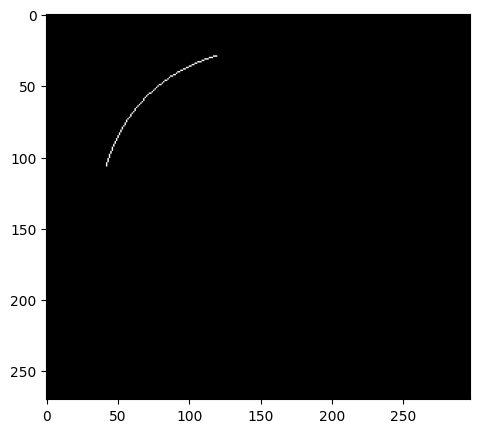

In [17]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-45)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

In [18]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*Amplitude,
                                                         Oy=Oy*Amplitude,
                                                         Oz=Oz*Amplitude,
                                                         NDelta=PMLThickness,
                                                         DT=TemporalStep,                                                         
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         SelMapsRMSPeakList=['Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=4,
                                                         TypeSource=1)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 5e-08 6.303432725005773e-08
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2273, temporal step = 5e-08, total sonication length 0.00011364 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 7
Allocating for V_x_x 3753415 elements
Allocating for V_y_x 3753415 elements
Allocating for V_z_x 3753415 elements
Allocating for V_x_y 3790135 elements
Allocating for V_y_y 3790135 elements
Allocating for V_z_y 3790135 elements
Allocating for V_x_z 3757762 elements
Allocating for V_y_z 3757762 elements
Allocating for V_z_z 37

### Ploting data

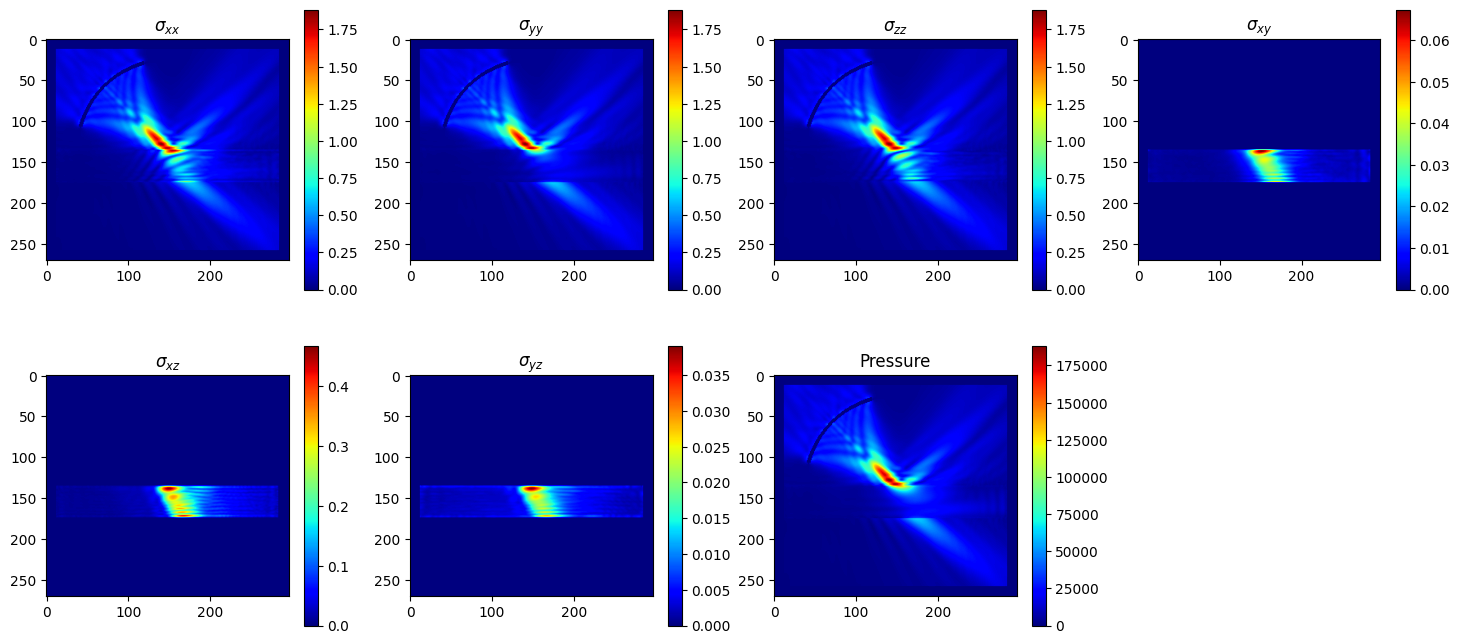

In [19]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    plt.imshow(selP.T,cmap=plt.cm.jet)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


In [20]:
ShowTimeData(N1,N2,N3,InputParam,SourceMap,Sensor).SelectTimePoint()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time point', layout=Layout(widt…

In this example, the transmitted field in the far field is much more coherent given that there is not mix between shear-mode and longitudinal-mode conversion. The field inside the solid shows  clearly a refracted field with a  transmission angle that is lower than the incident angle, which is expected as the shear speed of sound is less that the longitidunal speed of sound in water. Once the acoustic waves reaches the second water domain in the far field we obtain back a refracted beam that recovers the same transmission angle as the incident angle in the top domain.